In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils import data
from models.ConvTimeLSTM1 import ConvTime_LSTM1
from helper_fns.processing import scale_and_remove_na

<br><br><br><br>
# Required input

In [2]:
vol = "ErtaAle"
num_input_scenes = 10
train_percent = 0.70
out_samp_perc = 0.15 # validation and testing

<br><br><br><br>

# Basic data import

In [3]:
numpy_data_location = "data/" + vol + "/numpy_data_cube.npy"
table_data_location = "data/" + vol + "/good_df.csv"

In [4]:
volcano_scenes = np.load(numpy_data_location)
tabular_metadata = pd.read_csv(table_data_location)

print(volcano_scenes.shape)
tabular_metadata.head()

(265, 5, 96, 96)


,Unnamed: 0,X,nighttime_volcano_files,quality,dates,color,T_above_back
0,390,390,processed/AST_L1T_00310102000195018_2017080804...,y,2000-10-10,black,62.667978
1,411,411,processed/AST_L1T_00311022000195538_2017080804...,y,2000-11-02,black,60.253287
2,422,422,processed/AST_L1T_00311112000194941_2017080803...,y,2000-11-11,black,64.627377
3,430,430,processed/AST_L1T_00311182000195536_2017080803...,u,2000-11-18,red,52.487245
4,440,440,processed/AST_L1T_00311272000194916_2017080803...,y,2000-11-27,black,73.187710


<br><br><br><br>
# Separate model inputs (previous $n$ scenes, time differences) and outputs (subsequent scene)

In [5]:
# Determine number in each partition
train_n = int(np.floor((len(volcano_scenes) - num_input_scenes)*train_percent))
out_n = int(np.floor((len(volcano_scenes) - num_input_scenes)*out_samp_perc))

# For every data partition
# Array for the prior scenes
x_scenes_train = np.zeros([train_n,
                           num_input_scenes,
                           volcano_scenes.shape[1],
                           volcano_scenes.shape[2],
                           volcano_scenes.shape[3]])
x_scenes_valid = np.zeros([out_n,
                           num_input_scenes,
                           volcano_scenes.shape[1],
                           volcano_scenes.shape[2],
                           volcano_scenes.shape[3]])
x_scenes_test = np.zeros([out_n,
                          num_input_scenes,
                          volcano_scenes.shape[1],
                          volcano_scenes.shape[2],
                          volcano_scenes.shape[3]])
# Array for the time differences between scenes
time_differences_train = np.ones(x_scenes_train.shape)
time_differences_valid = np.ones(x_scenes_valid.shape)
time_differences_test = np.ones(x_scenes_test.shape)
# Array for the target scenes
y_scenes_train = np.zeros([train_n,
                           1,
                           volcano_scenes.shape[1],
                           volcano_scenes.shape[2],
                           volcano_scenes.shape[3]])
y_scenes_valid = np.zeros([out_n,
                           1,
                           volcano_scenes.shape[1],
                           volcano_scenes.shape[2],
                           volcano_scenes.shape[3]])
y_scenes_test = np.zeros([out_n,
                          1,
                          volcano_scenes.shape[1],
                          volcano_scenes.shape[2],
                          volcano_scenes.shape[3]])
# Array for the prior max temperature above the background
x_temperatures_train = np.zeros([train_n,
                                 num_input_scenes])
x_temperatures_valid = np.zeros([out_n,
                                 num_input_scenes])
x_temperatures_test = np.zeros([out_n,
                                num_input_scenes])
# Array for the target max temperature above the background
y_temperatures_train = np.zeros([train_n])
y_temperatures_valid = np.zeros([out_n])
y_temperatures_test = np.zeros([out_n])

In [6]:
# Formatting the string dates as datetime objects
formatted_dates = [datetime.strptime(date, '%Y-%m-%d') for date in tabular_metadata['dates']]

In [7]:
# For all observations - acknowledging that the first (n-1) wont have n prior observations
for i in range(num_input_scenes, x_scenes_train.shape[0] + x_scenes_valid.shape[0] + x_scenes_test.shape[0] + 10):
    if i < (train_n + num_input_scenes):
        # Store the image data
        x_scenes_train[i - num_input_scenes, :, :, :, :] = volcano_scenes[(i - num_input_scenes):i, :, :, :]
        y_scenes_train[i - num_input_scenes, 0, :, :, :] = volcano_scenes[i, :, :, :]
        # Store the max temperature scalars
        x_temperatures_train[i - num_input_scenes, :] = tabular_metadata['T_above_back'].values[(i - num_input_scenes):i]
        y_temperatures_train[i - num_input_scenes] = tabular_metadata['T_above_back'].values[i]
        # Compute the time differences and store
        dates_i_plus_1 = formatted_dates[(i - num_input_scenes + 1):(i + 1)]
        dates_i = formatted_dates[(i - num_input_scenes):i]
        for j in range(len(dates_i_plus_1)):
            time_differences_train[i - num_input_scenes, j] = (dates_i_plus_1[j] - dates_i[j]).days
    elif i < (train_n + out_n + num_input_scenes):
        # Store the image data
        x_scenes_valid[i - train_n - num_input_scenes, :, :, :, :] = volcano_scenes[(i - num_input_scenes):i, :, :, :]
        y_scenes_valid[i - train_n - num_input_scenes, 0, :, :, :] = volcano_scenes[i, :, :, :]
        # Store the max temperature scalars
        x_temperatures_valid[i - train_n - num_input_scenes, :] = tabular_metadata['T_above_back'].values[(i - num_input_scenes):i]
        y_temperatures_valid[i - train_n - num_input_scenes] = tabular_metadata['T_above_back'].values[i]
        # Compute the time differences and store
        dates_i_plus_1 = formatted_dates[(i - num_input_scenes + 1):(i + 1)]
        dates_i = formatted_dates[(i - num_input_scenes):i]
        for j in range(len(dates_i_plus_1)):
            time_differences_valid[i - train_n - num_input_scenes, j] = (dates_i_plus_1[j] - dates_i[j]).days
    else:
        # Store the image data
        x_scenes_test[i - train_n - out_n - num_input_scenes, :, :, :, :] = volcano_scenes[(i - num_input_scenes):i, :, :, :]
        y_scenes_test[i - train_n - out_n - num_input_scenes, 0, :, :, :] = volcano_scenes[i, :, :, :]
        # Store the max temperature scalars
        x_temperatures_test[i - train_n - out_n - num_input_scenes, :] = tabular_metadata['T_above_back'].values[(i - num_input_scenes):i]
        y_temperatures_test[i - train_n - out_n - num_input_scenes] = tabular_metadata['T_above_back'].values[i]
        # Compute the time differences and store
        dates_i_plus_1 = formatted_dates[(i - num_input_scenes + 1):(i + 1)]
        dates_i = formatted_dates[(i - num_input_scenes):i]
        for j in range(len(dates_i_plus_1)):
            time_differences_test[i - train_n - out_n - num_input_scenes, j] = (dates_i_plus_1[j] - dates_i[j]).days

<br><br><br><br>
# Viewing data
## Last input train sequence and first input validation sequence

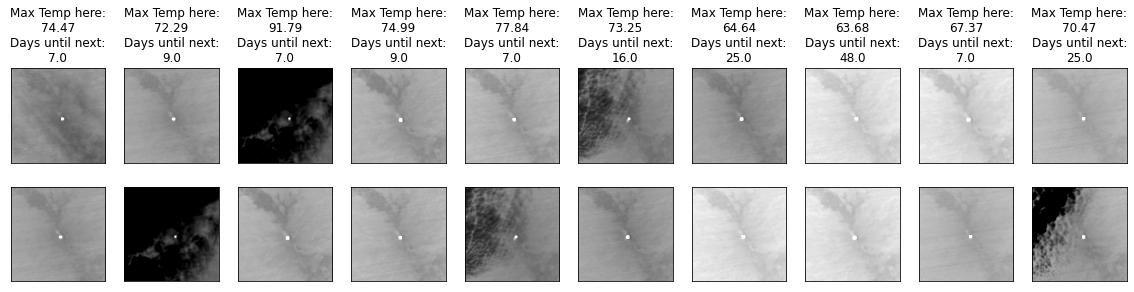

In [8]:
# Plot the previous observations in a short row
f, axarr = plt.subplots(2, num_input_scenes)
f.set_figheight(4)
f.set_figwidth(20)

# Gather color histogram values for color scaling
vmin, vmax = np.nanquantile(x_scenes_train, [0.01, 0.99])

# Plot all the previous observations
for i in range(num_input_scenes):
    axarr[0, i].imshow(x_scenes_train[-1, i, 2, :, :], cmap = 'gist_gray',
                    vmin = vmin, vmax = vmax)
    axarr[0, i].set_xticks([])
    axarr[0, i].set_yticks([])
    axarr[0, i].set_title('Max Temp here:\n' + str(np.around(x_temperatures_valid[-1, i], decimals = 2)) +
                       '\nDays until next:\n' + str(np.around(time_differences_valid[-1, i, 0, 0, 0], decimals = 0)))
    
    axarr[1, i].imshow(x_scenes_valid[0, i, 2, :, :], cmap = 'gist_gray',
                    vmin = vmin, vmax = vmax)
    axarr[1, i].set_xticks([])
    axarr[1, i].set_yticks([])

## Last input validation sequence and first input testing sequence

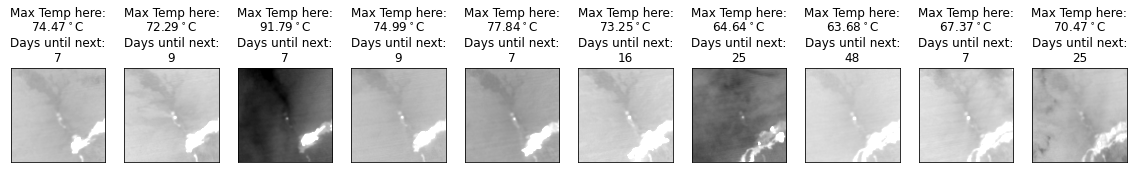

In [9]:
# Plot the previous observations in a short row
f, axarr = plt.subplots(1, num_input_scenes)
f.set_figheight(4)
f.set_figwidth(20)

# Gather color histogram values for color scaling
vmin, vmax = np.nanquantile(x_scenes_valid, [0.01, 0.99])

# Plot all the previous observations
for i in range(num_input_scenes):
    axarr[i].imshow(x_scenes_valid[-1, i, 2, :, :], cmap = 'gist_gray',
                    vmin = vmin, vmax = vmax)
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title('Max Temp here:\n' + str(np.around(x_temperatures_valid[-1, i], decimals = 2)) + "$^\circ$C" +
                       '\nDays until next:\n' + str(int(np.around(time_differences_valid[-1, i, 0, 0, 0], decimals = 0))))
    
    #axarr[1, i].imshow(x_scenes_test[0, i, 2, :, :], cmap = 'gist_gray',
    #                vmin = vmin, vmax = vmax)
    #axarr[1, i].set_xticks([])
    #axarr[1, i].set_yticks([])
    
plt.savefig('AGU_fig.png')

# Training sequence and its corresponding target scene

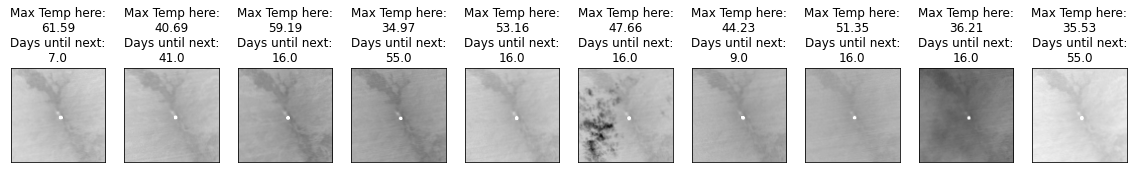

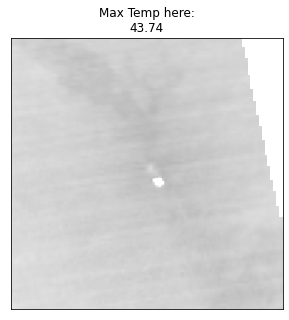

In [10]:
# Gather a random index
random_index = np.random.choice(train_n)

# Plot the previous observations in a short row
f, axarr = plt.subplots(1, num_input_scenes)
f.set_figheight(4)
f.set_figwidth(20)
    
# Gather color histogram values for color scaling
vmin, vmax = np.nanquantile(x_scenes_train, [0.01, 0.99])

# Plot all the previous observations
for i in range(num_input_scenes):
    axarr[i].imshow(x_scenes_train[random_index, i, 2, :, :], cmap = 'gist_gray',
                    vmin = vmin, vmax = vmax)
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title('Max Temp here:\n' + str(np.around(x_temperatures_train[random_index, i], decimals = 2)) +
                       '\nDays until next:\n' + str(np.around(time_differences_train[random_index, i, 0, 0, 0], decimals = 0)))

# Plot the target observation
plt.figure(figsize = (5, 5))
plt.imshow(y_scenes_train[random_index, 0, 2, :, :],
           cmap = 'gist_gray',
           vmin = vmin, vmax = vmax)
plt.title('Max Temp here:\n' + str(np.around(y_temperatures_train[random_index], decimals = 2)))
plt.xticks([]); plt.yticks([]);

## Scale temperatures between 0 and 1. If temperature is missing, assigned a scaled value of 0

In [11]:
x_scenes_train = scale_and_remove_na(x_scenes_train)
x_scenes_train = scale_and_remove_na(x_scenes_train)
x_scenes_train = scale_and_remove_na(x_scenes_train)

time_differences_train = scale_and_remove_na(time_differences_train)
time_differences_train = scale_and_remove_na(time_differences_train)
time_differences_train = scale_and_remove_na(time_differences_train)

y_scenes_train = scale_and_remove_na(y_scenes_train)
y_scenes_train = scale_and_remove_na(y_scenes_train)
y_scenes_train = scale_and_remove_na(y_scenes_train)

## Passing to pytorch and formatting

In [12]:
x_scenes_train = torch.from_numpy(x_scenes_train).type(torch.FloatTensor)
x_scenes_test = torch.from_numpy(x_scenes_test).type(torch.FloatTensor)
x_scenes_valid = torch.from_numpy(x_scenes_valid).type(torch.FloatTensor)

time_differences_train = torch.from_numpy(time_differences_train).type(torch.FloatTensor)
time_differences_test = torch.from_numpy(time_differences_test).type(torch.FloatTensor)
time_differences_valid = torch.from_numpy(time_differences_valid).type(torch.FloatTensor)

y_scenes_train = torch.from_numpy(y_scenes_train).type(torch.FloatTensor)
y_scenes_test = torch.from_numpy(y_scenes_test).type(torch.FloatTensor)
y_scenes_valid = torch.from_numpy(y_scenes_valid).type(torch.FloatTensor)

## Defining model parameters

In [13]:
# Picking one of the like-sequence tensors within the list to set parameters
channels = x_scenes_train.shape[2]
height = x_scenes_train.shape[3]
width = x_scenes_train.shape[4]

In [14]:
conv_time_lstm = ConvTime_LSTM1(input_size = (height,
                                              width),
                                input_dim = channels,
                                hidden_dim = [128, 64, 64, 1],
                                kernel_size = (5, 5),
                                num_layers = 4,
                                batch_first = True,
                                bias = True,
                                return_all_layers = False,
                                GPU = False)

In [15]:
time_differences_train[0:4, :, 0:1].shape, x_scenes_train[0:4].shape

(torch.Size([4, 10, 1, 96, 96]), torch.Size([4, 10, 5, 96, 96]))

In [17]:
conv_time_lstm(x_scenes_train[0:1],
               time_differences_train[0:1, :, 0:1])

torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 128, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])
torch.Size([1, 64, 96, 96])
torch.Size([1, 1, 96, 96])


([tensor([[[[[0.0008, 0.0007, 0.0008,  ..., 0.0008, 0.0008, 0.0007],
             [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0008, 0.0007],
             [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0007, 0.0007],
             ...,
             [0.0008, 0.0008, 0.0008,  ..., 0.0008, 0.0007, 0.0007],
             [0.0007, 0.0007, 0.0007,  ..., 0.0007, 0.0006, 0.0006],
             [0.0008, 0.0007, 0.0008,  ..., 0.0008, 0.0006, 0.0006]]],
  
  
           [[[0.0013, 0.0013, 0.0014,  ..., 0.0014, 0.0014, 0.0012],
             [0.0014, 0.0013, 0.0014,  ..., 0.0014, 0.0013, 0.0011],
             [0.0014, 0.0014, 0.0015,  ..., 0.0015, 0.0012, 0.0011],
             ...,
             [0.0014, 0.0014, 0.0015,  ..., 0.0015, 0.0012, 0.0011],
             [0.0012, 0.0011, 0.0011,  ..., 0.0011, 0.0008, 0.0009],
             [0.0013, 0.0012, 0.0013,  ..., 0.0013, 0.0010, 0.0010]]],
  
  
           [[[0.0017, 0.0016, 0.0018,  ..., 0.0018, 0.0017, 0.0015],
             [0.0018, 0.0017, 0.0018,  ..., 0.0018,

## Passing to GPU

In [15]:
conv_time_lstm.cuda()

ConvTime_LSTM2(
  (cell_list): ModuleList(
    (0): ConvTime_LSTM2Cell(
      (i_conv): Conv2d(133, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T1_conv_x): Conv2d(5, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T1_conv_t): Conv2d(5, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T2_conv_x): Conv2d(5, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T2_conv_t): Conv2d(5, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (c_conv): Conv2d(133, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (o_conv): Conv2d(138, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): ConvTime_LSTM2Cell(
      (i_conv): Conv2d(192, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T1_conv_x): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T1_conv_t): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (T2_conv_x): Conv2d(128, 64, kernel_size

## Setting optimization methods

In [16]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(conv_time_lstm.parameters())

## Defining data set and data loaders for parallelization

In [17]:
class train_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x_scenes_train[IDs, :, :, :, :]
        curr_t = time_differences_train[IDs, :, :, :, :]
        curr_y = y_scenes_train[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_t, curr_y)
    
class validation_Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_indices):
        'Initialization'
        self.data_indices = data_indices
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data_indices)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        IDs = self.data_indices[index]

        # Load data and get label
        curr_x = x_scenes_valid[IDs, :, :, :, :]
        curr_t = time_differences_valid[IDs, :, :, :, :]
        curr_y = y_scenes_valid[IDs, :, :, :, :]

        #return X, y
        return(curr_x, curr_t, curr_y)

In [18]:
training_set = train_Dataset(data_indices=range(y_scenes_train.shape[0]))
validation_set = validation_Dataset(data_indices=range(y_scenes_valid.shape[0]))

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset = training_set,
                                           batch_size = batch_size,
                                           shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_set,
                                                batch_size = batch_size,
                                                shuffle = True)

## Retrieving available computing devices and using parallel GPUs if available

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
conv_time_lstm = torch.nn.DataParallel(conv_time_lstm)

## Training loop

In [21]:
loss_list = []
epochs = int(np.ceil((7*10**5) / x_scenes_train.shape[0]))
for i in range(epochs):
    for data in train_loader:
        
        # data loader
        batch_x, batch_t, batch_y = data
        
        # move to GPU
        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)
        batch_y = batch_y.to(device)
        
        # run model and get the prediction
        batch_y_hat = conv_time_lstm(batch_x,
                                     batch_t)
        batch_y_hat = batch_y_hat[0][0][:, -2:-1, :, :, :]
        
        # calculate and store the loss
        batch_loss = loss(batch_y, batch_y_hat)
        loss_list.append(batch_loss.item())
        
        # update parameters
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        print('Epoch: ', i, '\n\tBatch loss: ', batch_loss.item(), '\n')
        
    print('Epoch: ', i, '\n\tBatch loss: ', batch_loss.item(), '\n')

torch.Size([16, 138, 96, 96])
torch.Size([16, 138, 96, 96])


RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 3.95 GiB total capacity; 3.07 GiB already allocated; 29.88 MiB free; 3.25 GiB reserved in total by PyTorch)